+ xlms 자료 구분(text 기준)
+ xlms 자료 읽기(특정범위)
+ xlms data 변환(data fill)
+ xlms data merge
+ bigquery upload

In [1]:
import csv
import xlrd
from pandas import DataFrame
import os
from os import listdir
from datetime import datetime, timedelta

import pandas as pd
import pandas_gbq
from datetime import datetime, timedelta
import time 
import re
from google.cloud import bigquery
from pandas.tseries.offsets import MonthEnd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

# 접속 정보 : local
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./boxwood-**************.json"
client = bigquery.Client()

In [10]:
sql = """
SELECT FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME)) as DATE
, round(sum(OrderAmt)/1000,0) as OrderAmt
, round(sum(OrderQty)/1000,0) as OrderQty
, round(sum(OrderVol)/1000,0) as OrderVol
, '실적' as gubun
FROM `boxwood-**************.SAP_BW.F_Order_Actual`
group by FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME))
union all
SELECT FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME)) as DATE
, round(sum(OrderAmt_plan)/1000,0) as OrderAmt
, round(sum(OrderQty_plan)/1000,0) as OrderQty
, round(sum(OrderVol_plan)/1000,0) as OrderVol
, '계획' as gubun
FROM `boxwood-**************.SAP_BW.F_Order_Plan`
group by FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME))
"""
df_search = client.query(sql).to_dataframe()
df_search= df_search.sort_values(by=['DATE']).reset_index(drop=True)

In [11]:
pd.options.display.float_format = '{:0,.0f}'.format
df0 = pd.pivot_table(df_search, values=['OrderAmt','OrderQty','OrderVol'], columns=['gubun'], index=['DATE'],  aggfunc='sum').fillna(0)

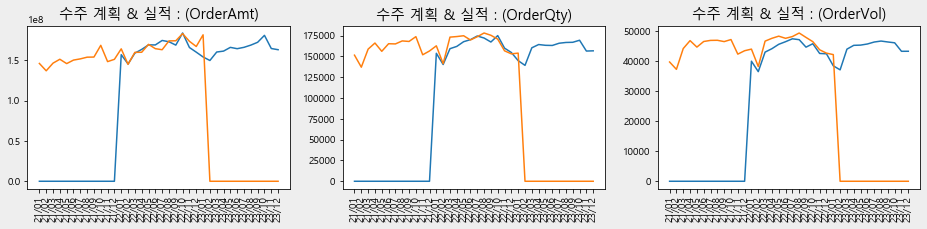

In [12]:
mpl.rc('figure', figsize=(16, 3))
fig = plt.figure( facecolor='#eeeeee')

plt.subplot(1,3,1)
plt.plot(df0.T.iloc[0:2].T)
plt.xticks(rotation=90)
plt.title('{} : ({})'.format('수주 계획 & 실적', 'OrderAmt'),fontsize='x-large')

plt.subplot(1,3,2)
plt.plot(df0.T.iloc[2:4].T)
plt.xticks(rotation=90)
plt.title('{} : ({})'.format('수주 계획 & 실적', 'OrderQty'),fontsize='x-large')

plt.subplot(1,3,3)
plt.plot(df0.T.iloc[4:].T)
plt.xticks(rotation=90)
plt.title('{} : ({})'.format('수주 계획 & 실적', 'OrderVol'),fontsize='x-large')

plt.show()

In [14]:
df0.tail(12)

OrderAmt             OrderQty         OrderVol       
gubun          계획          실적       계획      실적       계획     실적
DATE                                                          
23/01 154,299,199 181,778,427  144,972 154,029   38,436 42,169
23/02 149,910,618           0  139,301       0   37,096      0
23/03 160,427,792           0  160,413       0   43,980      0
23/04 161,556,476           0  164,352       0   45,251      0
23/05 166,194,547           0  163,419       0   45,327      0
23/06 164,556,857           0  163,227       0   45,701      0
23/07 166,251,572           0  165,910       0   46,356      0
23/08 169,003,068           0  166,838       0   46,678      0
23/09 172,507,640           0  167,040       0   46,372      0
23/10 181,112,243           0  169,503       0   46,094      0
23/11 164,775,481           0  156,511       0   43,269      0
23/12 163,299,902           0  156,782       0   43,282      0

### xlsm 자료 변환

In [2]:
# 경로 설정
directory_name = "./DATA"

# 파일명 가져오기
file_dir = listdir(directory_name)

In [3]:
file_dir

['ZPB_SD_Q013_F_Order_Plan_202310-202312.xlsx']

In [4]:
def read_data(f_name):
    df_temp = pd.read_excel(directory_name+'/' + f_name, sheet_name=0)
    col_nm ={
            "Unnamed: 5": "PrdName",
            }
    df_temp = df_temp.rename(columns=col_nm, errors="raise")
    try:
        df_temp['달력연도/월'] = df_temp['달력연도/월'].apply(str)
        df_temp['DATE'] = pd.to_datetime(df_temp['달력연도/월'], format='%Y-%m') + MonthEnd(0)
    except: 
        df_temp['DATE'] = pd.to_datetime(df_temp['달력일'])
    df_temp['자재'] = df_temp['자재'].apply(str)
    return df_temp


def rename_table_actual(dataset):
    col_nm ={
            "DATE"                  : "Date",
            "EIS 표준계층구조 1레벨": "EIS1",
            "EIS 표준계층구조 2레벨": "EIS2",
            "EIS 표준계층구조 3레벨": "EIS3",
            "자재"                  : "PrdCode",
            "고객계층구조레벨 1(N"  : "Chnl1",
            "고객계층구조레벨 2(N"  : "Chnl2",
            "고객계층구조레벨 3(N"  : "Chnl3",
            "수주수량"              : "OrderQty",
            "수주환산용량"          : "OrderVol",
            "수주금액"              : "OrderAmt",
            }
    df_t = dataset.rename(columns=col_nm, errors="raise")
    df_t['OrderAmt'] = df_t['OrderAmt'].astype(float)
    df_t['OrderQty'] = df_t['OrderQty'].astype(float)
    df_t['OrderVol'] = df_t['OrderVol'].astype(float)
    df_t = df_t[["EIS1", "EIS2", "EIS3", "PrdCode", "PrdName", "Date", "Chnl1", "Chnl2", "Chnl3", 
                 "OrderAmt", "OrderQty", "OrderVol" ]]
    return df_t




def rename_table_plan(dataset):
    col_nm ={
            "DATE"                  : "Date",
            "EIS 표준계층구조 1레벨": "EIS1",
            "EIS 표준계층구조 2레벨": "EIS2",
            "EIS 표준계층구조 3레벨": "EIS3",
            "자재"                  : "PrdCode",
            "고객계층구조레벨 1(N"  : "Chnl1",
            "고객계층구조레벨 2(N"  : "Chnl2",
            "고객계층구조레벨 3(N"  : "Chnl3",
            "판매계획수량"          : "OrderQty_plan",
            "판매계획수주환산용량"  : "OrderVol_plan",
            "판매계획금액"          : "OrderAmt_plan",
            }
    df_t = dataset.rename(columns=col_nm, errors="raise")
    df_t['OrderAmt_plan'] = df_t['OrderAmt_plan'].astype(float)
    df_t['OrderQty_plan'] = df_t['OrderQty_plan'].astype(float)
    df_t['OrderVol_plan'] = df_t['OrderVol_plan'].astype(float)
    df_t = df_t[["EIS1", "EIS2", "EIS3", "PrdCode", "PrdName", "Date", "Chnl1", "Chnl2", "Chnl3", 
                 "OrderAmt_plan", "OrderQty_plan", "OrderVol_plan" ]]
    return df_t

In [5]:
df_temp = read_data(file_dir[0])

In [6]:
df_temp = df_temp[df_temp['달력연도/월']=='2023-10']

In [25]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42916 entries, 0 to 42915
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   달력연도/월          42916 non-null  object        
 1   EIS 표준계층구조 1레벨  42916 non-null  object        
 2   EIS 표준계층구조 2레벨  42916 non-null  object        
 3   EIS 표준계층구조 3레벨  42916 non-null  object        
 4   자재              42916 non-null  object        
 5   PrdName         42916 non-null  object        
 6   고객계층구조레벨 1(N    42916 non-null  object        
 7   고객계층구조레벨 2(N    42916 non-null  object        
 8   고객계층구조레벨 3(N    42916 non-null  object        
 9   판매계획수량          42916 non-null  float64       
 10  판매계획수주환산용량      42916 non-null  float64       
 11  판매계획금액          42916 non-null  float64       
 12  DATE            42916 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(9)
memory usage: 4.3+ MB


### BigQuery 테이블 확인

In [23]:

#########
# 자료1 : rawdata 저장 목적
###
sql = """
    SELECT *
    FROM `boxwood-**************.SAP_BW.F_Order_Plan`
    limit 10
    """
df_format = client.query(sql).to_dataframe()

In [24]:
df_format

,EIS1,EIS2,EIS3,PrdCode,PrdName,Date,Chnl1,Chnl2,Chnl3,OrderAmt_plan,OrderQty_plan,OrderVol_plan


In [23]:

#########
# 자료1 : rawdata 저장 목적
###
sql = """
    SELECT FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME)) as DATE
    , min(FORMAT_DATETIME('%y/%m/%d', CAST(DATE AS DATETIME))) as DATE_min
    , max(FORMAT_DATETIME('%y/%m/%d', CAST(DATE AS DATETIME))) as DATE_max
    FROM `boxwood-**************.SAP_BW.F_Order_Actual`
    where CAST(DATE AS DATETIME) between DATE_SUB(current_date(), INTERVAL 3 month ) and DATE_SUB(current_date(), INTERVAL 0 month)
    group by FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME))
    """
df_search = client.query(sql).to_dataframe()

In [24]:
df_search

,DATE,DATE_min,DATE_max


### BigQuery에 자료 저장

In [19]:
def rename_table(dataset):
    col_nm ={
            "DATE"                : "Date",
            "EIS 표준계층구조 1레벨": "EIS1",
            "EIS 표준계층구조 2레벨": "EIS2",
            "EIS 표준계층구조 3레벨": "EIS3",
            "자재"                  : "PrdCode",
            "고객계층구조레벨 1(N"  : "Chnl1",
            "고객계층구조레벨 2(N"  : "Chnl2",
            "고객계층구조레벨 3(N"  : "Chnl3",
            "수주수량"              : "OrderQty",
            "수주환산용량"          : "OrderVol",
            "수주금액"              : "OrderAmt",
            }
    df_t = dataset.rename(columns=col_nm, errors="raise")
    df_t['OrderAmt'] = df_t['OrderAmt'].astype(float)
    df_t['OrderQty'] = df_t['OrderQty'].astype(float)
    df_t['OrderVol'] = df_t['OrderVol'].astype(float)
    df_t = df_t[["EIS1", "EIS2", "EIS3", "PrdCode", "PrdName", "Date", "Chnl1", "Chnl2", "Chnl3", 
                 "OrderAmt", "OrderQty", "OrderVol" ]]
    return df_t

In [27]:
df_temp.tail(2)

,달력연도/월,EIS 표준계층구조 1레벨,EIS 표준계층구조 2레벨,EIS 표준계층구조 3레벨,자재,PrdName,고객계층구조레벨 1(N,고객계층구조레벨 2(N,고객계층구조레벨 3(N,판매계획수량,판매계획수주환산용량,판매계획금액,DATE
42914,2023.12,기타 제품군,기타,치즈공방,106599,상하농원스트링치즈50G*10,상하영업,DEP,롯데백화점,24.025,1.20125,67261.01,2023-12-31
42915,2023.12,기타 제품군,기타,치즈공방,106599,상하농원스트링치즈50G*10,상하영업,DEP,이마트(PK),232.004,11.60020,551202.01,2023-12-31


In [25]:
def rename_table2(dataset):
    col_nm ={
            "DATE"                  : "Date",
            "EIS 표준계층구조 1레벨": "EIS1",
            "EIS 표준계층구조 2레벨": "EIS2",
            "EIS 표준계층구조 3레벨": "EIS3",
            "자재"                  : "PrdCode",
            "고객계층구조레벨 1(N"  : "Chnl1",
            "고객계층구조레벨 2(N"  : "Chnl2",
            "고객계층구조레벨 3(N"  : "Chnl3",
            "판매계획수량"          : "OrderAmt_plan",
            "판매계획수주환산용량"  : "OrderQty_plan",
            "판매계획금액"          : "OrderVol_plan",
            }
    df_t = dataset.rename(columns=col_nm, errors="raise")
    df_t['OrderAmt_plan'] = df_t['OrderAmt_plan'].astype(float)
    df_t['OrderQty_plan'] = df_t['OrderQty_plan'].astype(float)
    df_t['OrderVol_plan'] = df_t['OrderVol_plan'].astype(float)
    df_t = df_t[["EIS1", "EIS2", "EIS3", "PrdCode", "PrdName", "Date", "Chnl1", "Chnl2", "Chnl3", 
                 "OrderAmt_plan", "OrderQty_plan", "OrderVol_plan" ]]
    return df_t

In [26]:
rename_table2(df_temp).tail(2)

,EIS1,EIS2,EIS3,PrdCode,PrdName,Date,Chnl1,Chnl2,Chnl3,OrderAmt_plan,OrderQty_plan,OrderVol_plan
14045,기타 제품군,기타,치즈공방,106599,상하농원스트링치즈50G*10,2023-01-31,상하영업,DEP,롯데백화점,17.422,0.8711,48755.87
14046,기타 제품군,기타,치즈공방,106599,상하농원스트링치즈50G*10,2023-01-31,상하영업,DEP,이마트(PK),232.004,11.6002,551252.23


In [39]:
df_format

,EIS1,EIS2,EIS3,PrdCode,PrdName,Date,Chnl1,Chnl2,Chnl3,OrderAmt,OrderQty,OrderVol


In [17]:
rename_table2(df_temp).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76770 entries, 0 to 76769
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   EIS1           76770 non-null  object        
 1   EIS2           76770 non-null  object        
 2   EIS3           76770 non-null  object        
 3   PrdCode        76770 non-null  object        
 4   PrdName        76770 non-null  object        
 5   Date           76770 non-null  datetime64[ns]
 6   Chnl1          76770 non-null  object        
 7   Chnl2          76770 non-null  object        
 8   Chnl3          76770 non-null  object        
 9   OrderAmt_plan  76770 non-null  float64       
 10  OrderQty_plan  76770 non-null  float64       
 11  OrderVol_plan  76770 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 7.0+ MB


In [7]:
client = bigquery.Client()
project = 'boxwood-**************'
dataset_id = 'SAP_BW'
table_id = 'F_Order_Plan'
table_name = dataset_id +'.' +table_id

['ZPB_SD_Q013_F_Order_Plan_202201-202203.xlsx',
 'ZPB_SD_Q013_F_Order_Plan_202301.xlsx']

In [8]:
rename_table_plan(df_temp).tail(2)

,EIS1,EIS2,EIS3,PrdCode,PrdName,Date,Chnl1,Chnl2,Chnl3,OrderAmt_plan,OrderQty_plan,OrderVol_plan
14263,기타 제품군,기타,치즈공방,106599,상하농원스트링치즈50G*10,2023-10-31,상하영업,DEP,롯데백화점,70923.97,25.358,1.26790
14264,기타 제품군,기타,치즈공방,106599,상하농원스트링치즈50G*10,2023-10-31,상하영업,DEP,이마트(PK),581216.83,244.621,12.23105


In [33]:
%%time
for t_ in file_dir:
    pandas_gbq.to_gbq(rename_table_plan(read_data(t_)), table_name, project_id=project, if_exists = 'append' )

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Wall time: 2min 49s


In [9]:
pandas_gbq.to_gbq(rename_table_plan(df_temp), table_name, project_id=project, if_exists = 'append' )

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [56]:
project = 'boxwood-**************'
project_id = project

sql = """
SELECT FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME)) as DATE, count(*) as CNT
FROM `boxwood-**************.SAP_BW.F_Order_Plan`
group by FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME))
"""
df1 = pandas_gbq.read_gbq(sql, project_id=project_id)
df1 = df1.sort_values(by=['DATE']).reset_index(drop=True)

Downloading: 100%|███████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 70.33rows/s]


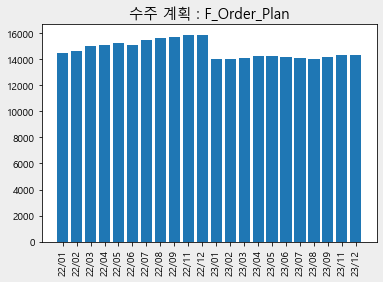

In [57]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

fig = plt.figure( facecolor='#eeeeee')
plt.bar(df1.DATE, df1.CNT)
plt.xticks(rotation=90)
plt.title('{} : {}'.format('수주 계획', 'F_Order_Plan'),fontsize='x-large')
plt.show()

In [21]:

#########
# 자료1 : rawdata 저장 목적
###
sql = """
    SELECT FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME)) as DATE
    , min(FORMAT_DATETIME('%y/%m/%d', CAST(DATE AS DATETIME))) as DATE_min
    , max(FORMAT_DATETIME('%y/%m/%d', CAST(DATE AS DATETIME))) as DATE_max
    FROM `boxwood-**************.SAP_BW.ZPB_SD_Q016`
    where CAST(DATE AS DATETIME) between DATE_SUB(current_date(), INTERVAL 3 month ) and DATE_SUB(current_date(), INTERVAL 0 month)
    group by FORMAT_DATETIME('%y/%m', CAST(DATE AS DATETIME))
    """
df_search = client.query(sql).to_dataframe()

In [22]:
df_search

,DATE,DATE_min,DATE_max
0,22/10,22/10/01,22/10/31
1,22/11,22/11/01,22/11/27
2,22/08,22/08/28,22/08/31
3,22/09,22/09/01,22/09/30
